In [722]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, invgamma
from scipy.special import gamma
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt

In [725]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

In [726]:
# hyperparameter 
GROUP_NUM = 5
GROUP_NAME = ["A", "B", "C", "D", "E"]
INGROUP_NUM = 10
mus = {GROUP_NAME[idx]: val for idx, val in enumerate(np.random.uniform(0, 2, 2 * GROUP_NUM).reshape(-1, 2))}
A = np.random.uniform(5, 10, (GROUP_NUM, 2, 2))
sigma_matrixs = []
for A in np.random.rand(GROUP_NUM, 2, 2):
    sigma_matrixs.append(A.T @ A)
sigma_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(sigma_matrixs)}

vs = {GROUP_NAME[idx]: val for idx, val in enumerate(np.random.uniform(4, 5, GROUP_NUM))}
ss = {GROUP_NAME[idx]: val for idx, val in enumerate(np.random.uniform(1/3, 1/2, GROUP_NUM))}

# grid points
GRID_NUM = 100
X_tilde = [[np.concatenate((np.ones((GRID_NUM, 1)), np.linspace(0, 2, GRID_NUM).reshape(-1, 1)), axis=1).tolist()] * INGROUP_NUM]
Xs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(X_tilde * GROUP_NUM))}
lambda_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate([np.eye(2)] * GROUP_NUM)}
weight_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([[np.eye(GRID_NUM)] * INGROUP_NUM] * GROUP_NUM))}
# print(np.all(np.linalg.eigvals(sigma_matrixs) > 0))

# prior
sigmas = []
for v, s in zip(vs.values(), ss.values()):
    sigmas.append(invgamma.rvs(a=v / 2, scale=10 * s / 2, size=INGROUP_NUM))
sigmas = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigmas))}

betas = []
for mu, sigma_all, sigma_matrix, lambda_matrix in \
    zip(mus.values(), sigmas.values(), sigma_matrixs.values(), lambda_matrixs.values()):
    beta = []
    for sigma in sigma_all:
        beta.append(multivariate_normal.rvs(mu, sigma * np.linalg.inv(lambda_matrix) @ np.linalg.inv(sigma_matrix)))
    betas.append(np.array(beta))
betas = {GROUP_NAME[idx]: val for idx, val in enumerate(betas)}

# data
ys_tilde = []
for beta_all, sigma_all, weight_matrix_all, X_tilde_all in \
    zip(betas.values(), sigmas.values(), weight_matrixs.values(), Xs_tilde.values()):
    y_tilde = []
    for beta, sigma, weight_matrix, X_tilde in zip(beta_all, sigma_all, weight_matrix_all, X_tilde_all):
        y_tilde.append(multivariate_normal.rvs(X_tilde @ beta, sigma * weight_matrix))
    ys_tilde.append(np.array(y_tilde))
ys_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(ys_tilde)}

In [1026]:
# hyperparameter 
GROUP_NUM = 5
GROUP_NAME = ["A", "B", "C", "D", "E"]
INGROUP_NUM = 5
mus = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([[5, 2]] * GROUP_NUM))}
A = np.random.uniform(5, 10, (GROUP_NUM, 2, 2))
sigma_matrixs = []
for A in np.random.rand(GROUP_NUM, 2, 2):
    # sigma_matrixs.append(A.T @ A)
    sigma_matrixs.append(np.eye(2))
sigma_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(sigma_matrixs)}

vs = {GROUP_NAME[idx]: val for idx, val in enumerate([4] * GROUP_NUM)}
ss = {GROUP_NAME[idx]: val for idx, val in enumerate([1/2] * GROUP_NUM)}

# grid points
GRID_NUM = 200
X_tilde = [[np.concatenate((np.ones((GRID_NUM, 1)), np.linspace(0, 2, GRID_NUM).reshape(-1, 1)), axis=1).tolist()] * INGROUP_NUM]
Xs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(X_tilde * GROUP_NUM))}
lambda_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate([np.eye(2)] * GROUP_NUM)}
weight_matrixs = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([[np.eye(GRID_NUM)] * INGROUP_NUM] * GROUP_NUM))}
# print(np.all(np.linalg.eigvals(sigma_matrixs) > 0))

# prior
sigmas = []
for v, s in zip(vs.values(), ss.values()):
    sigmas.append(invgamma.rvs(a=v / 2, scale=10 * s / 2, size=INGROUP_NUM))
sigmas = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigmas))}

betas = []
for mu, sigma_all, sigma_matrix, lambda_matrix in \
    zip(mus.values(), sigmas.values(), sigma_matrixs.values(), lambda_matrixs.values()):
    beta = []
    for sigma in sigma_all:
        beta.append(multivariate_normal.rvs(mu, sigma * np.linalg.inv(lambda_matrix) @ np.linalg.inv(sigma_matrix)))
    betas.append(np.array(beta))
betas = {GROUP_NAME[idx]: val for idx, val in enumerate(betas)}

# data
ys_tilde = []
for beta_all, sigma_all, weight_matrix_all, X_tilde_all in \
    zip(betas.values(), sigmas.values(), weight_matrixs.values(), Xs_tilde.values()):
    y_tilde = []
    for beta, sigma, weight_matrix, X_tilde in zip(beta_all, sigma_all, weight_matrix_all, X_tilde_all):
        y_tilde.append(multivariate_normal.rvs(X_tilde @ beta, sigma * weight_matrix))
    ys_tilde.append(np.array(y_tilde))
ys_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(ys_tilde)}

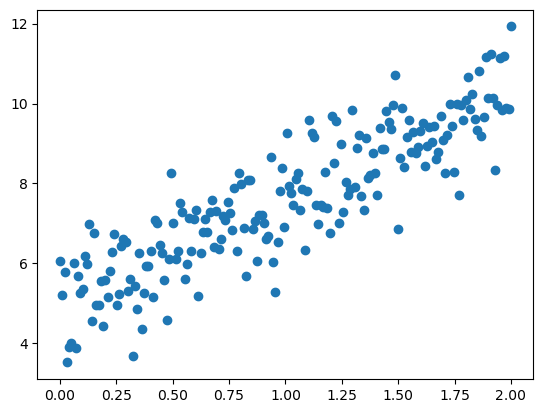

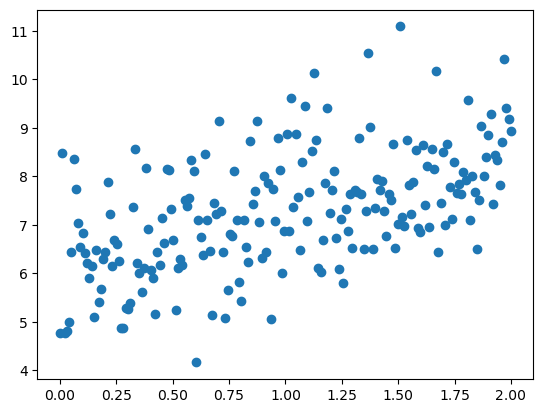

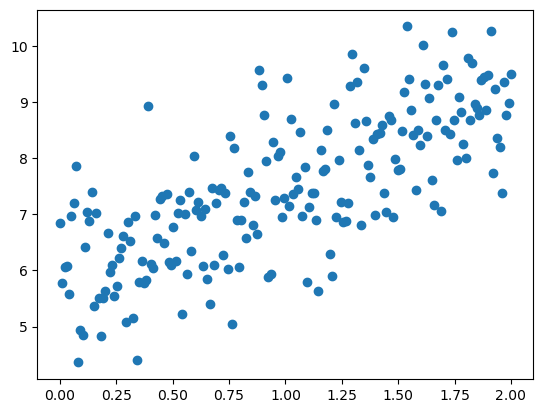

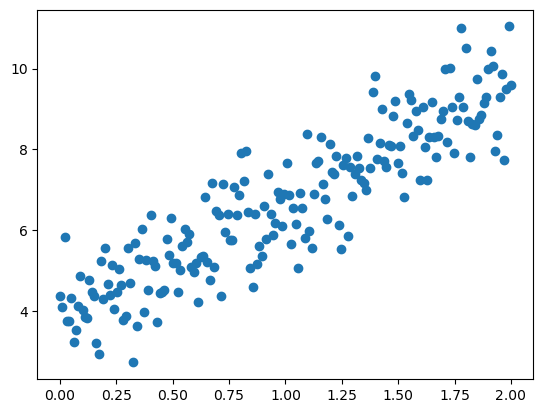

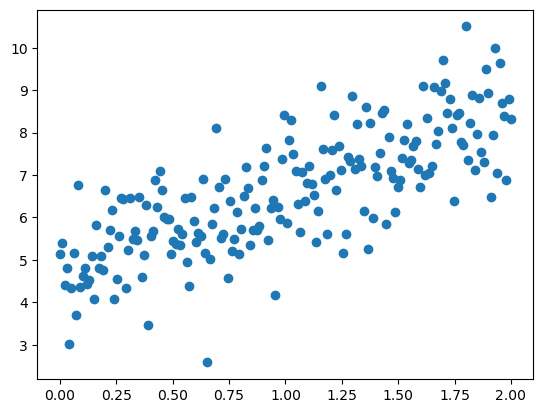

In [1027]:
for i in range(5):
    plt.scatter(Xs_tilde["A"][i][:, 1], ys_tilde["A"][i])
    plt.show()

In [898]:
def caculate_mus_tilde(
        Xs_tilde,
        ys_tilde, 
        weight_matrixs, 
        lambda_matrixs, 
        sigma_matrixs, 
        mus
        ):
    mus_tilde = []
    for y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, X_tilde_all in \
        zip(ys_tilde.values(), weight_matrixs.values(), lambda_matrixs.values(), \
            sigma_matrixs.values(), mus.values(), Xs_tilde.values()):
        mu_tilde = []
        for weight_matrix, X_tilde, y_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all):
            mu_tilde.append(np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ \
                            (X_tilde.T @ weight_matrix @ y_tilde + lambda_matrix @ sigma_matrix @ mu))
        mus_tilde.append(np.array(mu_tilde))
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(mus_tilde))}

In [733]:
mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)

In [648]:
def caculate_sigma_matrixs_tilde(
        Xs_tilde, 
        weight_matrixs, 
        lambda_matrixs, 
        sigma_matrixs
        ):
    sigma_matrixs_tilde = []
    for weight_matrix_all, lambda_matrix, sigma_matrix, X_tilde_all in \
        zip(weight_matrixs.values(), lambda_matrixs.values(), sigma_matrixs.values(), Xs_tilde.values()):
        sigma_matrix_tilde = []
        for weight_matrix, X_tilde in zip(weight_matrix_all, X_tilde_all):
            sigma_matrix_tilde.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))
        sigma_matrixs_tilde.append(np.array(sigma_matrix_tilde))
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigma_matrixs_tilde))}

In [649]:
def caculate_as_tilde(vs, grid_num):
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array([(v + grid_num) / 2 for v in vs.values()]))}

In [650]:
caculate_as_tilde(vs, 100)

{'A': 52.19347841096229,
 'B': 52.1569308939229,
 'C': 52.37182755255559,
 'D': 52.29911692242222,
 'E': 52.34602877603838}

In [780]:
def caculcate_bs_tilde(
        Xs_tilde,
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        sigma_matrixs, 
        vs, 
        ss, 
        mus_tilde, 
        mus
        ):
    
    bs_tilde = []
    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu, X_tilde_all in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus_tilde.values(), mus.values(), Xs_tilde.values()):
        b_tilde = []
        for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
            b = v * s / 2
            first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
            second = y_tilde.T @ weight_matrix @ y_tilde
            last = mu.T @ lambda_matrix @ sigma_matrix @ mu
            b_tilde.append(b + 1 / 2 * (-first + second + last))
        bs_tilde.append(np.array(b_tilde))
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(bs_tilde))}

In [652]:
def new_parameters(
        Xs_tilde, 
        ys_tilde, 
        weight_matrixs, 
        lambda_matrixs, 
        sigma_matrixs, 
        mus, 
        vs,
        ss, 
        grid_num
):
    mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)
    sigma_matrixs_tilde = []
    bs_tilde = []
    as_tilde = []
    
    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu, X_tilde_all in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus_tilde.values(), mus.values(), Xs_tilde.values()):
        sigma_matrix_tilde = []
        b_tilde = []
        for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
            
            sigma_matrix_tilde.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))

            b = v * s / 2
            first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
            second = y_tilde.T @ weight_matrix @ y_tilde
            last = mu.T @ lambda_matrix @ sigma_matrix @ mu
            b_tilde.append(b + 1 / 2 * (-first + second + last))

        sigma_matrixs_tilde.append(np.array(sigma_matrix_tilde))
        as_tilde.append([(v + grid_num) / 2] * INGROUP_NUM) 
        bs_tilde.append(np.array(b_tilde))
    
    sigma_matrix_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigma_matrixs_tilde))}
    a_tilde_all = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(as_tilde))}
    b_tilde_all = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(bs_tilde))}

    return mus_tilde, sigma_matrix_tilde, a_tilde_all, b_tilde_all



    # mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)
    # sigma_matrixs_tilde = caculate_sigma_matrixs_tilde(Xs_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs)
    # as_tilde = caculate_as_tilde(vs, grid_num)
    # bs_tilde = caculcate_bs_tilde(Xs_tilde, ys_tilde, lambda_matrixs, weight_matrixs, sigma_matrixs, vs, ss, mus_tilde, mus)
    
    # return mus_tilde, sigma_matrixs_tilde, as_tilde, bs_tilde

In [653]:
mus_tilde, sigma_matrixs_tilde, as_tilde, bs_tilde = new_parameters(
    Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus, vs, ss, GRID_NUM)

In [654]:
def empirical_bayes(mus_tilde, as_tilde, bs_tilde):
    sigmas_empirical_bayes = []
    for a_tilde, b_tilde_all in zip(as_tilde.values(), bs_tilde.values()):
        sigma_empirical_bayes = []
        for b_tilde in b_tilde_all:
            sigma_empirical_bayes.append(b_tilde / (a_tilde - 1))
        sigmas_empirical_bayes.append(np.array(sigma_empirical_bayes))
    return mus_tilde, {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigmas_empirical_bayes))}

In [655]:
betas_tilde, sigmas_tilde = empirical_bayes(mus_tilde, as_tilde, bs_tilde)

In [783]:
# betas_tilde["A"], betas["A"]

In [784]:
# sigmas_tilde["A"], sigmas["A"]

In [1028]:
def caculate_mu_mle(
        ys_tilde,
        lambda_matrixs,
        weight_matrixs,
        sigma_matrixs,
        vs,
        ss,
        mus,
        Xs_tilde,
        grid_num = GRID_NUM, 
        ingroup_num = INGROUP_NUM   
):
    mus_tilde = caculate_mus_tilde(Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus)
    sigma_matrixs_tilde_list = []
    bs_tilde_list = []
    as_tilde_list = []
    mus_mle_list = []

    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu, X_tilde_all in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus_tilde.values(), mus.values(), Xs_tilde.values()):
        
        sigma_matrix_tilde_list = []
        b_tilde_list = []
        weight_list = []
        inverse_weight_list = []
        for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
            
            sigma_matrix_tilde_list.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))

            a_tilde = (v + grid_num) / 2

            b = v * s / 2
            first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
            second = y_tilde.T @ weight_matrix @ y_tilde
            last = mu.T @ lambda_matrix @ sigma_matrix @ mu
            b_tilde = b + 1 / 2 * (-first + second + last)
            b_tilde_list.append(b_tilde)

            A = np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix)
            weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ A @ X_tilde.T @ weight_matrix @ y_tilde
            inverse_weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ \
                                                    np.linalg.inv(np.eye(2) - A @ lambda_matrix @ sigma_matrix)
            weight_list.append(weight)
            inverse_weight_list.append(inverse_weight)

        sigma_matrixs_tilde_list.append(np.array(sigma_matrix_tilde_list))
        as_tilde_list.append([(v + grid_num) / 2] * ingroup_num) 
        bs_tilde_list.append(np.array(b_tilde_list))
        mus_mle_list.append(np.linalg.inv(sum(inverse_weight_list)) @ sum(weight_list))

    mus_mle = {GROUP_NAME[idx]: val for idx, val in enumerate(mus_mle_list)}
    sigma_matrixs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(sigma_matrixs_tilde_list))}
    as_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(as_tilde_list))}
    bs_tilde = {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(bs_tilde_list))}

    return mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde

In [1029]:
mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde = caculate_mu_mle(
    ys_tilde, lambda_matrixs, weight_matrixs, sigma_matrixs, vs, ss, mus, Xs_tilde
    )

In [903]:
def caculcate_bs_tilde_single(
        X_tilde_all,
        y_tilde_all, 
        lambda_matrix, 
        weight_matrix, 
        sigma_matrix, 
        v, 
        s, 
        mu_tilde_all, 
        mu
        ):
    
    bs_tilde = []
    b_tilde = []
    for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
        b = v * s / 2
        first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
        second = y_tilde.T @ weight_matrix @ y_tilde
        last = mu.T @ lambda_matrix @ sigma_matrix @ mu
        b_tilde.append(b + 1 / 2 * (-first + second + last))
    bs_tilde.append(np.array(b_tilde))
    return {GROUP_NAME[idx]: val for idx, val in enumerate(np.array(bs_tilde))}

In [904]:
name = "A"
caculcate_bs_tilde_single(Xs_tilde[name], ys_tilde[name], lambda_matrixs[name], weight_matrixs[name], sigma_matrixs[name], vs[name], ss[name], mus_tilde[name], mus[name])

{'A': array([ 31.0177772 , 147.67650927, 129.07160809, 325.74684231,
        110.96437901])}

In [1034]:
def caculate_mus_tilde_single(
        X_tilde_all,
        y_tilde_all, 
        weight_matrix_all, 
        lambda_matrix, 
        sigma_matrix, 
        mu, 
        name
        ):
    mu_tilde = []
    for weight_matrix, X_tilde, y_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all):
        mu_tilde.append(np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ \
                        (X_tilde.T @ weight_matrix @ y_tilde + lambda_matrix @ sigma_matrix @ mu))
    return {name: np.array(mu_tilde)}

In [1036]:
caculate_mus_tilde_single(
        Xs_tilde[name], ys_tilde[name],
        weight_matrixs[name], 
        lambda_matrixs[name], 
        sigma_matrixs[name], 
        mus[name], 
        "A"
        )

{'A': array([[4.98859008, 2.62275233],
        [6.09454424, 1.1810728 ],
        [5.78324216, 1.67808902],
        [3.8345363 , 2.84957121],
        [4.72066712, 1.87733472]])}

In [1121]:
def caculate_mu_mle_single(
        X_tilde_all,
        y_tilde_all,
        weight_matrix_all,
        lambda_matrix,
        sigma_matrix,
        mu,
        v,
        s,
        name,
        grid_num = GRID_NUM, 
):
    mu_tilde_all = caculate_mus_tilde_single(X_tilde_all, y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, name)[name]
    
    sigma_matrix_tilde_list = []
    a_tilde_list = []
    b_tilde_list = []
    weight_list = []
    inverse_weight_list = []
    for weight_matrix, X_tilde, y_tilde, mu_tilde in zip(weight_matrix_all, X_tilde_all, y_tilde_all, mu_tilde_all):
        
        sigma_matrix_tilde_list.append(lambda_matrix @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))

        a_tilde = (v + grid_num) / 2
        a_tilde_list.append(a_tilde)

        b = v * s / 2
        first = mu_tilde.T @ (X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix) @ mu_tilde
        second = y_tilde.T @ weight_matrix @ y_tilde
        last = mu.T @ lambda_matrix @ sigma_matrix @ mu
        b_tilde = b + 1 / 2 * (-first + second + last)
        b_tilde_list.append(b_tilde)

        A = np.linalg.inv(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix)
        weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ A @ X_tilde.T @ weight_matrix @ y_tilde
        inverse_weight = a_tilde / b_tilde * sigma_matrix @ lambda_matrix @ \
                                                np.linalg.inv(np.eye(2) - A @ lambda_matrix @ sigma_matrix)
        weight_list.append(weight)
        inverse_weight_list.append(inverse_weight)


    mus_mle = {name: np.linalg.inv(sum(inverse_weight_list)) @ sum(weight_list)}
    sigma_matrixs_tilde = {name: np.array(sigma_matrix_tilde_list)}
    as_tilde = {name: np.array(a_tilde_list)}
    bs_tilde = {name: np.array(b_tilde_list)}

    return mu_tilde_all, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde

In [1006]:
GROUP_NAME = "A"

In [1057]:
def caculate_mu_mle(
        Xs_tilde,
        ys_tilde,
        weight_matrixs,
        lambda_matrixs,
        sigma_matrixs,
        mus,
        vs,
        ss,
        grid_num = GRID_NUM,  
):
    mus_tilde_dict = {}
    mus_mle_dict = {}
    sigma_matrixs_tilde_dict = {}
    as_tilde_dict = {}
    bs_tilde_dict = {}


    for y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu, X_tilde_all, name in \
        zip(ys_tilde.values(), lambda_matrixs.values(), weight_matrixs.values(), sigma_matrixs.values(), \
            vs.values(), ss.values(), mus.values(), Xs_tilde.values(), GROUP_NAME):
        
        mus_tilde_all, mus_mle_all, sigma_matrixs_tilde_all, as_tilde_all, bs_tilde_all = caculate_mu_mle_single(
            X_tilde_all, y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, v, s, name, grid_num
            )
        
        mus_tilde_dict.update(mus_tilde_all)
        mus_mle_dict.update(mus_mle_all)
        sigma_matrixs_tilde_dict.update(sigma_matrixs_tilde_all)
        as_tilde_dict.update(as_tilde_all)
        bs_tilde_dict.update(bs_tilde_all)

    return mus_tilde_dict, mus_mle_dict, sigma_matrixs_tilde_dict, as_tilde_dict, bs_tilde_dict

In [1070]:
mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde = caculate_mu_mle(
    Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs, mus, vs, ss, grid_num = GRID_NUM,  
)

In [1100]:
def negative_log_likelihood(
        v, 
        s, 
        sigma_matrix,
        Xs_tilde, 
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        mus, 
        name
):
    ans = 0
    a1 = 0
    a2 = 0
    a3 = 0
    a4 = 0

    X_tilde_all, y_tilde_all, lambda_matrix, weight_matrix_all, mu =\
    Xs_tilde[name], ys_tilde[name], lambda_matrixs[name], weight_matrixs[name], mus[name]

    mu_tilde_all = caculate_mus_tilde_single(X_tilde_all, y_tilde_all, weight_matrix_all, lambda_matrix, sigma_matrix, mu, name)[name]
    b_tilde_all = caculcate_bs_tilde_single(X_tilde_all, y_tilde_all, lambda_matrix, weight_matrix_all, sigma_matrix, v, s, mu_tilde_all, mu)[name]
    for X_tilde, b_tilde, weight_matrix in zip(X_tilde_all, b_tilde_all, weight_matrix_all):
        first = np.log(np.linalg.det(X_tilde.T @ weight_matrix @ X_tilde + lambda_matrix @ sigma_matrix))
        # second = np.log(np.linalg.det(weight_matrix))
        a = v / 2
        b = v * s / 2
        a_tilde = (v + GRID_NUM) / 2

        third = a * np.log(b)
        forth = np.log(gamma(a))
        fifth = np.log(gamma(a_tilde))
        sixth = a_tilde * np.log(b_tilde)

        a1 += 1 / 2 * first
        a2 += third - forth
        a3 += fifth
        a4 += sixth

        ans += 1 / 2 * first + third - forth + fifth - sixth
    return -ans

In [1101]:
name = "A"
negative_log_likelihood(vs[name], 
        ss[name], 
        sigma_matrixs[name],
        Xs_tilde, 
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        mus, 
        name)

384.77367419571044

In [1105]:
def estimator_negative_log_likelihood( 
        params, 
        Xs_tilde, 
        ys_tilde, 
        lambda_matrixs, 
        weight_matrixs, 
        mus, 
        name
        ):
    
    sigma_matrix = np.diag(params[: 2])
    v = params[2]
    s = params[3]
    return negative_log_likelihood(v, s, sigma_matrix, Xs_tilde, ys_tilde, \
                                   lambda_matrixs, weight_matrixs, mus, name)

In [1106]:
estimator_negative_log_likelihood(        
    [1, 1, 1, 1], 
    Xs_tilde, 
    ys_tilde, 
    lambda_matrixs, 
    weight_matrixs, 
    mus, 
    name="A"
    )

387.7695638616249

In [1107]:
objective_func = lambda params: estimator_negative_log_likelihood(        
    params, 
    Xs_tilde, 
    ys_tilde, 
    lambda_matrixs, 
    weight_matrixs,  
    mus, 
    name="A"
    )
res = minimize(objective_func, (2, 2, 1, 1), method='Nelder-Mead', bounds=((0, None), (0, None), (0, None), (0, None)))

In [1108]:
res.x

array([ 0.        ,  0.        , 96.44294377,  0.80489573])

In [1109]:
mus_initial = []
for X_tilde_all, y_tilde_all in zip(Xs_tilde.values(), ys_tilde.values()):
    mu_initial = []
    for X_tilde, y_tilde in zip(X_tilde_all, y_tilde_all):
        mu_initial.append(np.linalg.inv(X_tilde.T @ X_tilde) @ X_tilde.T @ y_tilde)
    mus_initial.append(np.mean(mu_initial, axis=0))
mus_initial = {GROUP_NAME[idx]: val for idx, val in enumerate(mus_initial)}

vs_initial = {GROUP_NAME[idx]: 2 for idx, _ in enumerate(mus_initial)}

ss_initial = []
for X_tilde_all, y_tilde_all, mu, v in zip(Xs_tilde.values(), ys_tilde.values(), mus_initial.values(), vs_initial.values()):
    s_initial = []
    for X_tilde, y_tilde in zip(X_tilde_all, y_tilde_all):
        s_initial.append((y_tilde - X_tilde @ mu).T @ (y_tilde - X_tilde @ mu) / v)
    ss_initial.append(np.mean(s_initial, axis=0))
ss_initial = {GROUP_NAME[idx]: val for idx, val in enumerate(ss_initial)}

sigma_matrixs_initial = {GROUP_NAME[idx]: val for idx, val in enumerate([np.eye(2)] * GROUP_NUM)}

In [1110]:
mus_tilde, mus_mle, sigma_matrixs_tilde, as_tilde, bs_tilde = caculate_mu_mle(
    Xs_tilde, ys_tilde, weight_matrixs, lambda_matrixs, sigma_matrixs_initial, mus_initial, vs_initial, ss_initial, grid_num = GRID_NUM,  
)

In [1111]:
objective_func = lambda params: estimator_negative_log_likelihood(        
    params, 
    Xs_tilde, 
    ys_tilde, 
    lambda_matrixs, 
    weight_matrixs, 
    mus_mle, 
    name="A"
    )
res = minimize(objective_func, (1, 1, 1, 1), method='Nelder-Mead', bounds=((0, None), (0, None), (0, None), (0, None)))

In [1183]:
def empirical_bayes_single(mu_tilde_all, as_tilde_all, bs_tilde_all):
    sigma_empirical_bayes = []
    for a_tilde, b_tilde in zip(*as_tilde_all.values(), *bs_tilde_all.values()):
        sigma_empirical_bayes.append(b_tilde / (a_tilde - 1))
    return mu_tilde_all, sigma_empirical_bayes

In [1181]:
def weight(weight_matrix_all, X_tilde_all, y_tilde_all, betas_em, sigmas_em, alpha):
    for idx, elements in enumerate(zip(X_tilde_all, y_tilde_all, betas_em, sigmas_em)):
        X_tilde, y_tilde, beta_em, sigma_em = elements
        coeff = ((1 + alpha) / ((2 * np.pi )**(alpha / 2) * sigma_em**(alpha / 2 + 1)))
        exponential = np.exp(-(alpha / (2 * sigma_em)) * (y_tilde - X_tilde @ beta_em)**2)
        weight_matrix_all[idx] = np.diag(coeff * exponential)
    return weight_matrix

In [1182]:
for name in GROUP_NAME:
    for i in range(10):
        objective_func = lambda params: estimator_negative_log_likelihood(        
        params, Xs_tilde, ys_tilde, lambda_matrixs, weight_matrixs, mus_mle, name
        )
        res = minimize(objective_func, (1, 1, 1, 1), method='Nelder-Mead', bounds=((0.1, None), (0.1, None), (0, None), (0, None)))

        sigma_matrix = np.diag((res.x[:2]))
        v = res.x[2]
        s = res.x[3]
        
        mu_tilde_all, mu_mle, sigma_matrixs_tilde_all, as_tilde_all, bs_tilde_all = caculate_mu_mle_single(
            Xs_tilde[name], ys_tilde[name], weight_matrixs[name], lambda_matrixs[name], sigma_matrix, mus_initial[name], v, s, name, GRID_NUM
            )
        
        betas_em, sigmas_em = empirical_bayes_single(mu_tilde_all, as_tilde_all, bs_tilde_all)
        weight(weight_matrixs[name], Xs_tilde[name], ys_tilde[name], betas_em, sigmas_em, 0.1)
        
        print(mu_mle)
        print(sigma_matrix)
        print(v)
        print(s)
        print("-"*10)
        
    break

{'A': array([114.3597533, 114.3597533, 114.3597533, 114.3597533, 114.3597533])}
{'A': array([5.03982987, 2.07595277])}
[[0.1 0. ]
 [0.  0.1]]
28.719506593572916
0.8268094155174711
----------
{'A': array([114.17156553, 114.17156553, 114.17156553, 114.17156553,
       114.17156553])}
{'A': array([5.02267424, 2.09345498])}
[[0.1 0. ]
 [0.  0.1]]
28.34313106961952
0.8277709461116769
----------
{'A': array([114.32241747, 114.32241747, 114.32241747, 114.32241747,
       114.32241747])}
{'A': array([5.03651701, 2.07928771])}
[[0.1 0. ]
 [0.  0.1]]
28.64483493048334
0.8269948522842788
----------
{'A': array([114.2022738, 114.2022738, 114.2022738, 114.2022738, 114.2022738])}
{'A': array([5.02531752, 2.09078133])}
[[0.1 0. ]
 [0.  0.1]]
28.404547601258475
0.8276227223380934
----------
{'A': array([114.29848612, 114.29848612, 114.29848612, 114.29848612,
       114.29848612])}
{'A': array([5.03435981, 2.08147354])}
[[0.1 0. ]
 [0.  0.1]]
28.59697224973245
0.82711527300198
----------
{'A': array([1

In [1185]:
mu_tilde_all

array([[4.98903988, 2.62692512],
       [6.10961727, 1.14491758],
       [5.79157043, 1.6694879 ],
       [3.8037885 , 2.872895  ],
       [4.73131359, 1.87020485]])

In [1165]:
weight(weight_matrixs[name], Xs_tilde[name], ys_tilde[name], betas_em, sigmas_em, 0.1)

array([1.27937104, 0.75833767, 1.26396106, 1.41264927, 0.99100045])

In [1215]:
from .model import *

ImportError: attempted relative import with no known parent package